# 2D-Gap surrogate modeling by means of Multi-fidelity Gaussian Process Regression

This notebook covers the procedure of how to use multiple fidelities in order to obtain a better Gaussian process surrogate model with less computational cost. The setup assumes the 2D-Pad gap size problem with two features $h_0$ and $r_s$ as introduced in Notebook 1.

In order to get started, a modified version of `GPy` which accomodates multi-fidelity Gaussian processes has been downloaded and imported into this folder. Any updates to the code in the future is available on github and can be found [here](https://github.com/taylanot/GPy). In order to avoid confusion with the existing `GPy` framework (without multi-fidelity), <ins>the modified module containing the multi-fidelity code should be renamed</ins>. In this notebook, the name `GPy_MF` is chosen.

In [1]:
import GPy_MF.models

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


Afterwards, some standard packages are imported.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(123)

Next, the input data is set-up on which the surrogate model will be built.

In [3]:
Xc1 = np.linspace(50, 200, 10).reshape(-1,1) # Design parameter range for r_s
Xc2 = np.linspace(30, 34.18, 10).reshape(-1,1) # Design parameter range for  h_0
xxc, yyc = np.meshgrid(Xc1, Xc2) # For plotting

# Design grid on which the Gaussian processes are to be predicted
des_grid_x = np.linspace(50, 200, 100)
des_grid_y = np.linspace(30, 34.18, 100)
des_grid_xx, des_grid_yy = np.meshgrid(des_grid_x, des_grid_y)
des_grid = np.array([des_grid_xx.reshape(-1, 1), des_grid_yy.reshape(-1, 1)]).squeeze().T

Next, the response data should be introduced. Please refer to Notebook 1 to see how this data is generated. To be precise, we have sampled the 2D response surfaces in a 10x10 grid in multiple different fidelity settings.

In what follows, two fidelities are considered when performing the regression; one low fidelity and one high fidelity. The (reference) high-fidelity response surface is provided in `resp_data_HF.csv`, and an assortment of five different types of low fidelity sweeps can be found in `resp_data_LF1.csv` through `resp_data_LF5.csv`. All files are also equipped with the input data for `r_s` and `h_0`.

Here is a table summarizing the models that generated the responses:

| HF | LF1 | LF2 | LF3 | LF4 | LF5 |
| --- | --- | --- | --- | --- | --- |
| Original mesh & mass | Coarser mesh only | 10x mass scale only | 25x mass scale only | Coarser mesh & 10x mass scale | Coarser mesh & 25x mass scale |

In [4]:
df_LF = pd.read_csv('Data/resp_data_LF5.csv')
df_HF = pd.read_csv('Data/resp_data_HF.csv')

Xc = np.array(df_LF[['rs', 'h0']]).reshape((100, 2))

scaler = StandardScaler() # Data needs to be scaled for regression
scaler.fit(Xc)
Xc_scaled = scaler.transform(Xc)
des_grid_scaled = scaler.transform(des_grid)

CheapResp = np.array(df_LF['gap']).reshape((10, 10)) # Other low-fidelity response surfaces can be selected here.
ExpensiveResp = np.array(df_HF['gap']).reshape((10, 10))

Yc = CheapResp.reshape(-1, 1)
Ye_full = ExpensiveResp.reshape(-1, 1)

Expensive_DoE_indices = np.random.choice(100, 10, replace=False)

Xe = Xc[Expensive_DoE_indices]
Xe_scaled = Xc_scaled[Expensive_DoE_indices]

Ye = Ye_full[Expensive_DoE_indices]

### MFGPR method input setup

x = des_grid_scaled

Xl = Xc_scaled
Xh = Xe_scaled

X = [Xl, Xh]

Yl = Yc
Yh = Ye

Y = [Yl, Yh]

Now that all the data has been prepared to perform the regression, we first construct a (single-fidelity) reference Gaussian process surrogate model for the 10x10 high-fidelity response surface. 
The radial basis function (RBF) kernel used for the GP regression has three hyper-parameters: `rbf.variance`, `rbf.lengthscale` and `Gaussian_noise.variance`. These hyperparameters are able to be optimized within `GPy` by means of maximizing the log marginal likelihood of the Gaussian process. Here, the (default) L-BFGS-B algorithm is used, and other algorithms are available. Please refer to the [documentation of `GPy`](https://gpy.readthedocs.io/en/deploy/index.html).

In [5]:
mExp = GPy_MF.models.GPRegression(Xl, Ye_full) # Full expensive GPR surrogate

### Uncomment any of the following lines to fix a certain hyperparameter to a predetermined value. ###
# mExp.parameters[0]['rbf.variance'].fix(0.5)
# mExp.parameters[0]['rbf.lengthscale'].fix(0.5)
# mExp.parameters[1]['Gaussian_noise.variance'].fix(0.5)

mExp.optimize(max_iters=4)

muExp, sigmaExp = mExp.predict(x)

mExp_lim = GPy_MF.models.GPRegression(Xh, Ye) # Restricted expensive GPR surrogate
mExp_lim.optimize(max_iters=4)
muExp_lim, sigmaExp_lim = mExp_lim.predict(x)

The multi-fidelity GPR is performed below. Since the same kernel is used, we are dealing with the same hyper-parameters (for each fidelity) and they are optimized in the same way.

In [6]:
m = GPy_MF.models.multiGPRegression(X, Y) # Multi-fidelity GPR surrogate

### Uncomment any of the following lines to fix a certain hyperparameter to a predetermined value. ###
# m.models[0]['Gaussian_noise.variance'].fix(0.1)
# m.models[0]['rbf.variance'].fix(1)
# m.models[0]['rbf.lengthscale'].fix(1)
# m.models[1]['Gaussian_noise.variance'].fix(0.05)
# m.models[1]['rbf.variance'].fix(1)
# m.models[1]['rbf.lengthscale'].fix(1)

m.optimize_restarts(restarts=4, verbose=False)

mu_mf, sigma_mf = m.predict(x)

Next, we can output and analyze the hyperparameters and $R^2$-scores.

In [7]:
# (MF)GPR hyperparameters
print('Single-fidelity reference GPR:')
print(mExp)
print('--------------------------------')

print('Multi-fidelity GPR:')
print(m)
print('--------------------------------')

# Coefficients of determination
print('R-squared score of full expensive GPR surface compared with...')
print('Cheap GPR surface:', r2_score(muExp, mu_mf[0]))
print('Expensive GPR surface:', r2_score(muExp, muExp_lim))
print('Multi-fidelity GPR surface:', r2_score(muExp, mu_mf[1]))

Single-fidelity reference GPR:

Name : GP regression
Objective : -318.4180686110133
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |    0.41526043886271125  |      +ve      |        
  rbf.lengthscale          |     2.8306679198989633  |      +ve      |        
  Gaussian_noise.variance  |  6.211715594838965e-05  |      +ve      |        
--------------------------------
Multi-fidelity GPR:

Name : fidelity-1-GP
Objective : -390.23553530629795
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  fidelity_m_1_m_GP.       |                   value  |  constraints  |  priors
  rbf.variance             |    0.015803899940669715  |      +ve      |        
  rbf.lengthscale          |      12.172853468900914  |      +ve      |        
  Gaussian_noise.variance  |  1.8119846275496305e-05  |      +ve      |  

As is evident from the final two lines from the previous cell, the multi-fidelity Gaussian process surrogate model is (much) more accurate than when either just the low- or high-fidelity FE model output is considered.

This last code cell is meant to visualize the computed results.

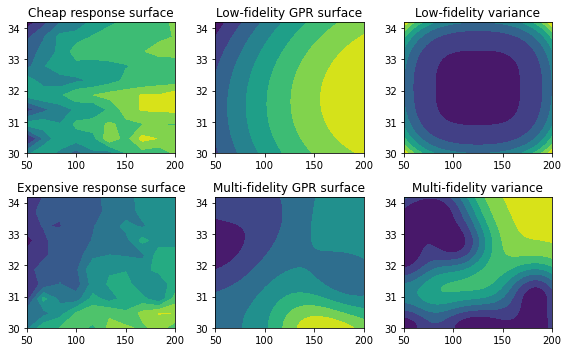

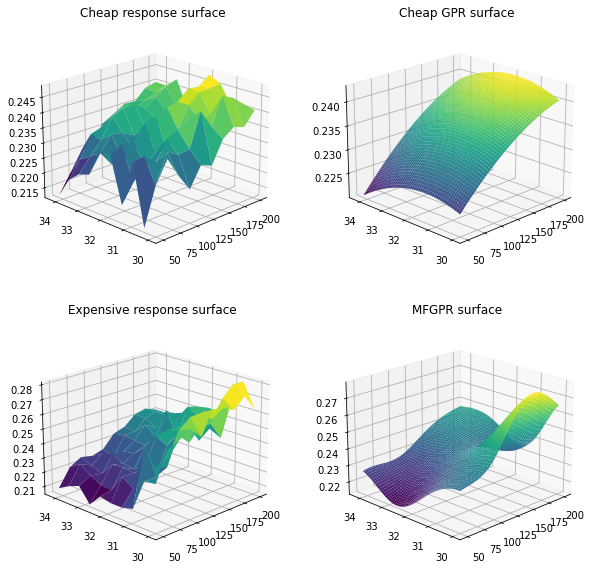

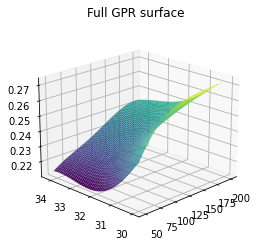

In [8]:
mu = [a.reshape(np.shape(des_grid_xx)) for a in mu_mf]
sigma = [a.reshape(np.shape(des_grid_xx)) for a in sigma_mf]

### Visualization

fig1, axs1 = plt.subplots(2, 3, figsize=(8, 5))

axs1[0, 0].contourf(xxc, yyc, CheapResp.reshape(np.shape(xxc)))
axs1[0, 0].set_title('Cheap response surface')

axs1[1, 0].contourf(xxc, yyc, ExpensiveResp.reshape(np.shape(xxc)))
axs1[1, 0].set_title('Expensive response surface')

axs1[0, 1].contourf(des_grid_xx, des_grid_yy, mu[0])
axs1[0, 1].set_title('Low-fidelity GPR surface')

axs1[1, 1].contourf(des_grid_xx, des_grid_yy, mu[1])
axs1[1, 1].set_title('Multi-fidelity GPR surface')

axs1[0, 2].contourf(des_grid_xx, des_grid_yy, sigma[0])
axs1[0, 2].set_title('Low-fidelity variance')

axs1[1, 2].contourf(des_grid_xx, des_grid_yy, sigma[1])
axs1[1, 2].set_title('Multi-fidelity variance')

plt.tight_layout()

fig2 = plt.figure(figsize=(10, 10))

ax1 = fig2.add_subplot(2, 2, 1, projection='3d')
ax1.view_init(20, 225)
ax1.plot_surface(xxc, yyc, CheapResp.reshape(np.shape(xxc)), cmap='viridis')
ax1.set_title('Cheap response surface')

ax2 = fig2.add_subplot(2, 2, 2, projection='3d')
ax2.view_init(20, 225)
ax2.plot_surface(des_grid_xx, des_grid_yy, mu[0], cmap='viridis')
ax2.set_title('Cheap GPR surface')

ax3 = fig2.add_subplot(2, 2, 3, projection='3d')
ax3.view_init(20, 225)
ax3.plot_surface(xxc, yyc, ExpensiveResp.reshape(np.shape(xxc)), cmap='viridis')
ax3.set_title('Expensive response surface')

ax4 = fig2.add_subplot(2, 2, 4, projection='3d')
ax4.view_init(20, 225)
ax4.plot_surface(des_grid_xx, des_grid_yy, mu[1], cmap='viridis')
ax4.set_title('MFGPR surface')

fig3 = plt.figure()
axEx = fig3.add_subplot(1, 1, 1, projection='3d')
axEx.view_init(20, 225)
axEx.plot_surface(des_grid_xx, des_grid_yy, muExp.reshape(np.shape(des_grid_xx)), cmap='viridis')
axEx.set_title('Full GPR surface')

plt.show()